In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from tqdm import tqdm_notebook as tqdm
import random
import seaborn as sns

import agent
import blockworld

from blockworld import Blockworld

%matplotlib inline
%load_ext autoreload
%autoreload 2

from collections import namedtuple
# Putting this up here to avoid redefinition to make pickling easier
ModelResult = namedtuple('ModelResult', ['name', 'agent_kwargs', 'fit'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def make_letters(start, number):
    '''
    Returns list of `number` letters, starting from `start`. Letters are generated in ASCII sequence.
    >>> make_letters('A', 3)
    ['A', 'B', 'C']
    >>> make_letters('D', 3)
    ['D', 'E', 'F']
    '''
    return [chr(ord(start) + i) for i in range(number)]

import doctest
assert doctest.testmod().failed == 0

def generate_blockworld_problem(
    B,
    heights,
):
    '''
    Generate blockworld problem.

    The problem has number of letters B and spaces S.
    To generate, we randomly select a letter (without replacement)
    and place it at a random space, ensuring that height constraints
    are satisfied.
    '''
    S = len(heights)
    problems = []
    letters = make_letters('A', B)
    spaces = range(S)

    # You have B letters and S spaces. Until all have been placed,
    # choose random letter without replacement to put at random space.
    initial = [() for _ in spaces]
    for letter in np.random.permutation(letters):
        space = np.random.choice([s for s in spaces if len(initial[s]) < heights[s]])
        initial[space] += (letter,)
    return tuple(initial), letters

heights = (3, 2, 1)
initial, letters = generate_blockworld_problem(3, heights)
print('Sample initial state', initial, 'with letters', letters)

Sample initial state (('B',), ('C',), ('A',)) with letters ['A', 'B', 'C']


In [3]:
# Generate many problems.
# Ask all k agents to perform on this task: k=1, k=2, k=3, etc.
# - either run things multiple times or consider enumerating all solutions the agents would consider.
# Fit various depth models to agent behaviors.
# Find problems that
# - recover the parameter used to generate the data (defined by appropriate parameter is greater LL than others) and
# - also maximize diff in LL between appropriate k and max d

def gen_goals(state):
    '''
    Here's our standard way to generate goals: center column, no debug info.
    '''
    return blockworld.Blockworld.generate_tower_of_london_goals(state, column_index=1, debug=False)

def generate_agent_data(initial):
    generated_df = dict(pid=[], states=[], actions=[], kwargs=[])
    g = gen_goals(initial)

    repetitions = 5

    for agent_name, agent_kwargs in [
        ('k=1', dict(k=1)) for _ in range(repetitions)
    ] + [
        ('k=2', dict(k=2)) for _ in range(repetitions)
    ] + [
        ('k=3', dict(k=3)) for _ in range(repetitions)
    ] + [
        ('k=4', dict(k=4)) for _ in range(repetitions)
    ]:
        problem = blockworld.Blockworld(initial, g)
        history, completed = agent.solve_using_ordered_goal_subset_astar(
            problem, debug=False, shuffle=True, **agent_kwargs)
        states = [s for a, s in history]
        actions = [a for a, s in history if a is not None]
        assert len(actions) == len(states) - 1
        generated_df['states'].append(states)
        generated_df['actions'].append(actions)
        generated_df['pid'].append(agent_name)
        generated_df['kwargs'].append(agent_kwargs)

    return pd.DataFrame(generated_df)

initial = ((), ('C', 'A', 'B'), ('E', 'D'))

import random
random.seed(1338)

generated_df = generate_agent_data(initial)
generated_df.tail()

,pid,states,actions,kwargs
15,k=4,"[((), (C, A, B), (E, D)), ((), (C, A), (E, D, ...","[(B, 2), (A, 0), (B, 0), (C, 0), (D, 0), (E, 1...",{'k': 4}
16,k=4,"[((), (C, A, B), (E, D)), ((B,), (C, A), (E, D...","[(B, 0), (A, 0), (C, 0), (D, 0), (E, 1), (D, 1...",{'k': 4}
17,k=4,"[((), (C, A, B), (E, D)), ((), (C, A), (E, D, ...","[(B, 2), (A, 0), (B, 0), (C, 0), (D, 0), (E, 1...",{'k': 4}
18,k=4,"[((), (C, A, B), (E, D)), ((), (C, A), (E, D, ...","[(B, 2), (A, 0), (B, 0), (C, 0), (D, 0), (E, 1...",{'k': 4}
19,k=4,"[((), (C, A, B), (E, D)), ((B,), (C, A), (E, D...","[(B, 0), (A, 0), (C, 0), (D, 0), (E, 1), (D, 1...",{'k': 4}


In [4]:
def fit_p_err(model_p, rand_p, debug=False):
    def noisy_model_p(p_err):
        return (1 - p_err) * model_p + p_err * rand_p

    # indexing trick [:, None] adds new dim to use vectorized ops via broadcasting
    p_err = np.linspace(0,1)[:, None]
    logp = np.log(noisy_model_p(p_err))
    total_logp = logp.sum(-1)  # sum logp across trials
    if debug:
        print('p_err.shape', p_err.shape, 'logp.shape', logp.shape, 'total_logp.shape', total_logp.shape)
    i = np.argmax(total_logp)
    best_p_err = p_err.squeeze()[i]

    if debug:
        plt.plot(p_err, total_logp)
        plt.xlabel('Error Probability')
        plt.ylabel('Log Likelihood')
        plt.axvline(best_p_err, c='r', ls='--', label='MLE Error Probability')
        plt.legend()

    return dict(p_err=best_p_err, logp=total_logp[i])

agent_idx = 0
_, row = next(generated_df.iterrows())
problem = blockworld.Blockworld(row.states[0], gen_goals(row.states[0]))
model_p = p_actions # [:, agent_idx]
rand_p = np.array([1/len(problem.actions(s)) for s in row.states[:-1]])
print('model_p.shape', model_p.shape, 'rand_p.shape', rand_p.shape)
print('MLE error prob:', fit_p_err(model_p, rand_p, debug=True))

NameError: name 'p_actions' is not defined

In [114]:
from functools import lru_cache

# We want to see what an agent would do in each circumstance.

@lru_cache(maxsize=2048)
def get_actions(state, k=None, depth_limit=None):
    goals_with_clearing = gen_goals(state)

    if k is None:
        k = len(goals_with_clearing)
    problem = blockworld.Blockworld(state, goals_with_clearing)
    # HACK could use next_goal to find out how far into states to go
    next_goal, goal_test, h = agent.make_ordered_k_goal_cost_heuristic(problem, state, k=k, debug=False)
    solutions = agent.A_Star(
        problem,
        h,
        start=state,
        goal_test=goal_test,
        depth_limit=depth_limit,
        return_all_equal_cost_paths=True,
        shuffle=False)
    # HACK do we just get next actions or the action sequence?
    # Returning sequence might afford some optimizations outside of this function.
    next_actions = [actions[0] for actions, states in solutions]
    # HACK we should decide how to deal with repeated actions. More repetitions means
    # more solutions are in that part of the subtree.
    return next_actions

# We compute the probability that each agent would take the action the participant took.

def probability_of_actions_for_agent(row, get_actions_fn, uniform_action_selection=False):
    p_action = np.zeros((len(row.actions),))

    for action_idx, (state, participant_action) in enumerate(zip(row.states[:-1], row.actions)):
        agent_actions = get_actions_fn(state)
        if uniform_action_selection:
            agent_actions = list(set(agent_actions))
        # HACK for now we assume each action from agent is of equal likelihood. In future, we might prefer compute_action_path_probabilities
        same_action = sum(1 if a == participant_action else 0 for a in agent_actions)
        p_action[action_idx] = same_action / len(agent_actions)

    return p_action

k_agents = [
    (f'k={k}', dict(k=k))
    for k in [1, 2, 3, 4]
]
other_agents = [
    (f'd={d}', dict(depth_limit=d))
    for d in [2, 3, 4, 5, 6, 7, 8, 9]
]

# have to choose how to combine LL across multiple runs: do we take average LL ? or average difference?
# or fit model across all runs (which I like most rn)

def model_generated_data_for_problem(curr_df, with_progress=False, k_agents=k_agents, other_agents=other_agents):
    def _make_models(filt, agents):
        models = []
        for agent_name, agent_kwargs in agents:
            get_actions_fn = lambda s: get_actions(s, **agent_kwargs)
            model_p = []
            rand_p = []
            for _, row in filt.iterrows():
                model_p.append(probability_of_actions_for_agent(row, get_actions_fn, uniform_action_selection=True))
                rand_p.append(np.array([1/len(problem.actions(s)) for s in row.states[:-1]]))
            model_p = np.concatenate(model_p)
            rand_p = np.concatenate(rand_p)
            assert model_p.shape == rand_p.shape
            models.append(ModelResult(agent_name, agent_kwargs, fit_p_err(model_p, rand_p, debug=False)))
        return models

    d = []
    pids = list(sorted(curr_df.pid.unique()))
    if with_progress:
        pids = tqdm(pids)
    for pid in pids:
        filt = curr_df.loc[curr_df.pid == pid]
        d.append(dict(
            agent_name=pid,
            # If their pid matches, then their kwargs definitely match.
            agent_kwargs=filt.kwargs.values[0],
            k_models=_make_models(filt, k_agents),
            other_models=_make_models(filt, other_agents),
        ))
    return pd.DataFrame(d)

res = model_generated_data_for_problem(generated_df.tail(), with_progress=True)
for m in res.k_models.values[0] + res.other_models.values[0]:
    print(m)

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


ModelResult(name='k=1', agent_kwargs={'k': 1}, fit={'p_err': 0.08163265306122448, 'logp': -7.254533440815227})
ModelResult(name='k=2', agent_kwargs={'k': 2}, fit={'p_err': 0.0, 'logp': -1.3862943611198906})
ModelResult(name='k=3', agent_kwargs={'k': 3}, fit={'p_err': 0.0, 'logp': -0.6931471805599453})
ModelResult(name='k=4', agent_kwargs={'k': 4}, fit={'p_err': 0.0, 'logp': -1.3862943611198906})
ModelResult(name='d=2', agent_kwargs={'depth_limit': 2}, fit={'p_err': 0.0, 'logp': -8.55333223803211})
ModelResult(name='d=3', agent_kwargs={'depth_limit': 3}, fit={'p_err': 0.0, 'logp': -6.761572768804055})
ModelResult(name='d=4', agent_kwargs={'depth_limit': 4}, fit={'p_err': 0.0, 'logp': -6.761572768804055})
ModelResult(name='d=5', agent_kwargs={'depth_limit': 5}, fit={'p_err': 0.1020408163265306, 'logp': -8.962797110468594})
ModelResult(name='d=6', agent_kwargs={'depth_limit': 6}, fit={'p_err': 0.08163265306122448, 'logp': -7.240655750988578})
ModelResult(name='d=7', agent_kwargs={'depth_l

In [115]:
def score_problem(df):
    diffs = []
    parameter_recovereds = []

    for _, row in df.iterrows():
        generating_model = next(m for m in row.k_models if m.agent_kwargs == row.agent_kwargs)
        parameter_recovered = True

        # parameter recovery, ensuring generating model has higher logp than other models.
        for m in row.k_models:
            if m.agent_kwargs == row.agent_kwargs:
                continue
            if m.fit['logp'] > generating_model.fit['logp']:
                parameter_recovered = False

        # Find diff in logp between generating & maximal other model
        max_model = max(row.other_models, key=lambda m: m.fit['logp'])
        diff = generating_model.fit['logp'] - max_model.fit['logp']
        diffs.append(diff)
        parameter_recovereds.append(parameter_recovered)

    return parameter_recovereds, diffs

score_problem(res)

([False, False, True, True, True],
 [0.0,
  0.6931471805599452,
  -3.383072868496656,
  3.688879454113936,
  0.6931471805599452])

In [116]:
initial = (('D',), ('E', 'C'), ('F', 'B', 'A'))

generated_df = generate_agent_data(initial)
modeled = model_generated_data_for_problem(generated_df)
s = score_problem(modeled)
display(s)
for _, row in modeled.iterrows():
    print('\n\n', row.agent_name)
    for m in row.k_models + row.other_models:
        print('\t', m)

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


([True, True, True, False],
 [8.553481346808518,
  3.465735902799727,
  -2.0794415416798344,
  4.477643702128635])



 k=1
	 ModelResult(name='k=1', agent_kwargs={'k': 1}, fit={'p_err': 0.0, 'logp': -9.010913347279288})
	 ModelResult(name='k=2', agent_kwargs={'k': 2}, fit={'p_err': 0.061224489795918366, 'logp': -25.209827097945293})
	 ModelResult(name='k=3', agent_kwargs={'k': 3}, fit={'p_err': 0.02040816326530612, 'logp': -18.94035311489081})
	 ModelResult(name='k=4', agent_kwargs={'k': 4}, fit={'p_err': 0.12244897959183673, 'logp': -35.76677117731978})
	 ModelResult(name='d=2', agent_kwargs={'depth_limit': 2}, fit={'p_err': 0.0, 'logp': -36.528336565121045})
	 ModelResult(name='d=3', agent_kwargs={'depth_limit': 3}, fit={'p_err': 0.0, 'logp': -22.76962495620017})
	 ModelResult(name='d=4', agent_kwargs={'depth_limit': 4}, fit={'p_err': 0.02040816326530612, 'logp': -23.286817306292512})
	 ModelResult(name='d=5', agent_kwargs={'depth_limit': 5}, fit={'p_err': 0.02040816326530612, 'logp': -19.349133617107594})
	 ModelResult(name='d=6', agent_kwargs={'depth_limit': 6}, fit={'p_err': 0.06122448979591836

In [12]:
#d = {} # this variable stores all problems we've worked on.

In [186]:
for BLOCKS in (5, 6):
    for _ in tqdm(range(2000)):
        initial, letters = generate_blockworld_problem(BLOCKS, (BLOCKS, BLOCKS, BLOCKS))
        if initial in d:
            continue
        generated_df = generate_agent_data(initial)
        modeled = model_generated_data_for_problem(generated_df)
        #score = score_problem(modeled) # we actually want `modeled` so we can tweak the scoring
        d[initial] = modeled

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [207]:
import pickle
with open('kd-generated.pickle', 'wb') as f:
    pickle.dump(d, f)
'''
# Use this if there's a problem with modelresult being incorrect???
for k, hidf in d.items():
    for _, row in hidf.iterrows():
        for idx, m in enumerate(row.k_models):
            row.k_models[idx] = ModelResult(*m)
        for idx, m in enumerate(row.other_models):
            row.other_models[idx] = ModelResult(*m)
'''
None

In [188]:
dkeys_by_blocknum = {}
for k in d.keys():
    dkeys_by_blocknum.setdefault(sum(len(col) for col in k), []).append(k)
keys5 = dkeys_by_blocknum[5]
keys6 = dkeys_by_blocknum[6]
print('All keys', len(d.keys()), *[f'{b} keys: {len(v)},' for b, v in dkeys_by_blocknum.items()])

All keys 6331 5 keys: 1815, 6 keys: 4123, 3 keys: 60, 4 keys: 333,


In [229]:
#scored = {k: score_problem(m) for k, m in tqdm(d.items())}
#key = lambda k: np.sum(np.array(scored[k][-1]) * np.array([1, 1, 1, 3])) # weighted sum
#key = lambda k: scored[k][-1][3] # prioritize by score of k=4
key = lambda k: sum(scored[k][-1]) # sum is nice

for kvalidx in range(3):
    key = lambda k: scored[k][-1][kvalidx]
    print(f'k={kvalidx+1}')
    for k in sorted(dkeys_by_blocknum[6], key=key, reverse=True)[:10]:
        s = scored[k]
        print(k, s)

k=1
(('F',), ('B', 'D', 'A', 'C', 'E'), ()) ([True, True, True, True], [32.369453481761376, 3.4657359027997257, 7.333994210510838, 12.29184672250341])
(('E',), ('D', 'B', 'A', 'C'), ('F',)) ([True, True, False, True], [30.342127941220554, 15.890269151739725, -0.6286200188908033, 3.465735902799726])
(('F',), ('D', 'A', 'B', 'C'), ('E',)) ([True, True, True, True], [30.342127941220554, 5.493061443340549, 5.493061443340549, 3.465735902799726])
(('F', 'E'), ('B', 'D', 'C', 'A'), ()) ([True, True, True, True], [27.90933729257156, 0.0, 5.49306144334055, 0.0])
(('F', 'B'), ('D', 'A', 'C', 'E'), ()) ([True, True, True, True], [27.046291075216224, 5.49306144334055, 5.49306144334055, -9.954265685094128])
(('F',), ('D', 'C', 'A', 'E', 'B'), ()) ([True, True, True, True], [26.876392038420825, 0.0, 0.0, 0.0])
(('F',), ('B', 'D', 'C', 'E', 'A'), ()) ([True, True, True, True], [26.876392038420825, 0.0, 4.9176972984369876, 0.0])
(('F',), ('D', 'C', 'B', 'E', 'A'), ()) ([True, True, True, True], [26.87

In [17]:
# repeatability of scores...

initial = (('E',), ('C', 'A', 'D'), ('F', 'B'))

generated_df = generate_agent_data(initial)
modeled = model_generated_data_for_problem(generated_df)
s = score_problem(modeled)
display(s)

print('run it again...')
generated_df = generate_agent_data(initial)
modeled = model_generated_data_for_problem(generated_df)
s = score_problem(modeled)
display(s)

print('one last time...')
generated_df = generate_agent_data(initial)
modeled = model_generated_data_for_problem(generated_df)
s = score_problem(modeled)
display(s)

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


(True,
 [9.651944526700222,
  33.96042383476965,
  12.323855681186558,
  14.978661367769952])

run it again...


(True,
 [16.583416332299674,
  30.65866788962815,
  12.729320789294722,
  14.978661367769952])

one last time...


(True,
 [15.197121971179783,
  27.307175407857326,
  11.918390573078394,
  14.978661367769952])

In [169]:
#previous_runs = []

In [208]:
# assessing previous thigns we've looked at
prev = [((), ('C', 'A', 'B'), ('E', 'D')),
 ((), ('C', 'A', 'E'), ('D', 'B')),
 (('C',), ('A', 'E', 'B', 'D'), ()),
 (('C',), ('B', 'E', 'D', 'A'), ()),
 (('C', 'E'), ('A', 'B', 'D'), ()),
 (('C', 'E'), ('B', 'A', 'D'), ()),
 (('C', 'E', 'A'), ('B', 'D'), ()),
 (('D', 'A'), ('C', 'B', 'E'), ()),
 (('D', 'B'), ('A', 'E', 'C'), ()),
 (('E',), ('C', 'B', 'A'), ('D',)),
 (('E', 'A'), ('C', 'B'), ('D',)),
 (('E', 'B'), ('C', 'A', 'D'), ()),
 (('E', 'B', 'D'), ('C', 'A'), ()),
 (('E', 'C', 'A'), ('B',), ('D',)),
 (('E', 'D'), ('C', 'A', 'B'), ())]

# now try best N-blocks
prev = sorted(dkeys_by_blocknum[3], key=lambda k: sum(scored[k][-1]), reverse=True)[:15]
# Actually pick some things that maximize each k
'''
prev = [
    k
    for kidx in range(len(k_agents))
    for k in sorted(
        keys6,
        key=lambda k: scored[k][-1][kidx], # we prioritize by LL diff for each k-value
        reverse=True,
    )[:4] # We pick the first 4 options for each of the 4 k. So 16 problems total.
]
'''
num_prev = len(prev)
prev = list(set(prev))
print(f'{len(prev)} unique out of {num_prev}')

res = []
for initial in tqdm(prev):
    generated_df = generate_agent_data(initial)
    generated_df['pid'] = generated_df['pid'].str.cat([f':{i}' for i in range(generated_df.shape[0])])
    res.append(generated_df)

generated_df = pd.concat(res)

# HACK for now we are just trying this here
'''
other_agents = [
    (f'd={d}', dict(depth_limit=d))
    for d in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
]
'''

# HACK it seems like jointly modeling is better than selecting with respect to the way we identified it by optimizing
# HACK this can be _very_ slow since we don't really exploit LRU very well with how inner loop is run.
modeled = model_generated_data_for_problem(generated_df, with_progress=True, other_agents=other_agents)

previous_runs.append((prev, modeled))

15 unique out of 15


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [151]:
modeled.head()

,agent_kwargs,agent_name,k_models,other_models
0,{'k': 1},k=1:0,"[(k=1, {'k': 1}, {'p_err': 0.0, 'logp': -13.86...","[(d=2, {'depth_limit': 2}, {'p_err': 0.0, 'log..."
1,{'k': 1},k=1:1,"[(k=1, {'k': 1}, {'p_err': 0.0, 'logp': -13.86...","[(d=2, {'depth_limit': 2}, {'p_err': 0.0, 'log..."
2,{'k': 1},k=1:2,"[(k=1, {'k': 1}, {'p_err': 0.0, 'logp': -13.16...","[(d=2, {'depth_limit': 2}, {'p_err': 0.0, 'log..."
3,{'k': 1},k=1:3,"[(k=1, {'k': 1}, {'p_err': 0.0, 'logp': -13.86...","[(d=2, {'depth_limit': 2}, {'p_err': 0.0, 'log..."
4,{'k': 1},k=1:4,"[(k=1, {'k': 1}, {'p_err': 0.0, 'logp': -14.55...","[(d=2, {'depth_limit': 2}, {'p_err': 0.0, 'log..."


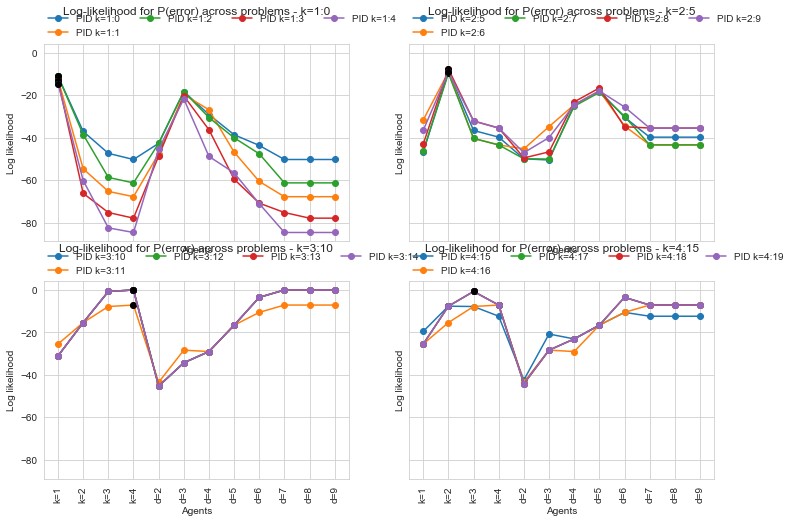

In [191]:
sns.set_style("whitegrid")

f, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

for ax, pids in [
    #sorted(curr_df.pid.unique()),
    (ax, [pid for pid in generated_df.pid.unique() if pid.startswith(agent_type)])
    for ax, agent_type in zip(axes.flat, ['k=1', 'k=2', 'k=3', 'k=4'])
]:
    for pid in pids:
        pid_df = modeled.loc[modeled.agent_name == pid]
        assert pid_df.shape[0] == 1
        _, pid_df_row = next(pid_df.iterrows())
        models = pid_df_row.k_models + pid_df_row.other_models
        names = [m.name for m in models]
        ll = [m.fit['logp'] for m in models]
        ax.plot(names, ll, '-o', label=f'PID {pid}')
        max_agent = np.argmax(ll)
        max_dot = ax.plot(names[max_agent], ll[max_agent], 'o', c='k')

    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=4, 
                borderaxespad=0, frameon=False)

    ax.set_title(f'Log-likelihood for P(error) across problems - {list(pids)[0]}\n\n')
    ax.set_xlabel('Agents')
    ax.set_ylabel('Log likelihood')
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

In [240]:
def _get_main_problems():
    '''
    To find our main problems for testing, we take the top problems
    that best differentiate each of different k. We vary the number
    of top problems to make sure k=1/k=2 are best differentiated.
    We also ensure problems are removed if their mirror is also
    in the set of problems.
    '''

    k_to_lim = {
        1: 5,
        2: 5,
        3: 4,
        4: 4,
    }

    main_problems = [
        k
        for kidx in range(len(k_agents))
        for k in sorted(
            dkeys_by_blocknum[6],
            key=lambda k: scored[k][-1][kidx], # we prioritize by LL diff for each k-value
            reverse=True,
        )[:k_to_lim[kidx+1]] # We pick the first $lim options for each of the 4 k.
    ]

    print(f'{len(set(main_problems))} unique problems out of {len(main_problems)}')

    def _count_dupes(problemset):
        return len([p for p in problemset if p[::-1] in problemset]) / 2

    print(f'Total dupes: {_count_dupes(main_problems)}')

    deduplicated = [p for p in main_problems if p[::-1] not in main_problems or p < p[::-1]]

    print(f'# Without duplicates... {len(deduplicated)}')
    print(f'Total dupes after dedupe: {_count_dupes(deduplicated)}')

    return deduplicated

_ = _get_main_problems()

18 unique problems out of 18
Total dupes: 2.0
# Without duplicates... 16
Total dupes after dedupe: 0.0


In [244]:
ps = _get_main_problems()
print('(')
for p in ps:
    print('  '+str(p)+',')
print(')')

18 unique problems out of 18
Total dupes: 2.0
# Without duplicates... 16
Total dupes after dedupe: 0.0
(
  (('F',), ('B', 'D', 'A', 'C', 'E'), ()),
  (('E',), ('D', 'B', 'A', 'C'), ('F',)),
  (('F',), ('D', 'A', 'B', 'C'), ('E',)),
  (('F', 'E'), ('B', 'D', 'C', 'A'), ()),
  (('F', 'B'), ('D', 'A', 'C', 'E'), ()),
  (('E', 'B'), ('A', 'D'), ('F', 'C')),
  (('E',), ('C', 'A', 'D'), ('F', 'B')),
  (('E',), ('C',), ('F', 'B', 'A', 'D')),
  (('E', 'D'), (), ('F', 'C', 'A', 'B')),
  (('F', 'E', 'A'), ('B', 'C'), ('D',)),
  (('F', 'E', 'C'), ('B', 'A'), ('D',)),
  (('E',), ('B',), ('F', 'C', 'D', 'A')),
  (('F', 'C', 'E'), ('A',), ('D', 'B')),
  ((), ('A', 'C', 'E', 'F'), ('D', 'B')),
  (('F', 'C', 'B', 'A'), (), ('D', 'E')),
  (('F', 'D'), ('B', 'C'), ('E', 'A')),
)


In [206]:
_goal_from_state = lambda s: ((), tuple(sorted([l for col in s for l in col], reverse=True)), ())
print(_goal_from_state(keys5[0]))

def _get_top(kval, num=4):
    return sorted(
        dkeys_by_blocknum[kval],
        key=lambda k: sum(scored[k][-1]),
        reverse=True)[:num]

main_problems = [
    k
    for kidx in range(len(k_agents))
    for k in sorted(
        dkeys_by_blocknum[6],
        key=lambda k: scored[k][-1][kidx], # we prioritize by LL diff for each k-value
        reverse=True,
    )[:4] # We pick the first 4 options for each of the 4 k. So 16 problems total.
]

print(f'{len(set(main_problems))} unique problems out of {len(main_problems)}')

info = [
    ('B=3', [(('A', 'C'), (), ('B',))]),
    ('B=4', _get_top(4)),
    ('B=5', _get_top(5)),
    ('B=6', main_problems),
]

out = {}

for problem_type, top in info:
    print(problem_type)
    out[problem_type] = result = []
    for initial in top:
        print(initial, scored[initial])
        result.append(dict(
            initial=initial,
            goal=_goal_from_state(initial),
        ))
    print()

import json
with open('trials.json', 'w') as f:
    json.dump(out, f)

((), ('E', 'D', 'C', 'B', 'A'), ())
16 unique problems out of 16
B=3
(('A', 'C'), (), ('B',)) ([True, True, True, True], [0.0, 0.0, 0.0, 0.0])

B=4
((), ('A', 'C'), ('D', 'B')) ([True, True, True, True], [2.457226915232364, 5.49306144334055, 0.0, 0.0])
(('D', 'B'), ('A', 'C'), ()) ([True, True, True, True], [3.465735902799726, 2.831589124714257, 0.0, 0.0])
((), ('A', 'B', 'D'), ('C',)) ([True, True, True, True], [2.027325540540823, 3.4657359027997265, 0.0, 0.0])
((), ('B',), ('D', 'A', 'C')) ([True, True, True, True], [2.027325540540822, 3.4657359027997257, 0.0, 0.0])

B=5
(('D',), (), ('E', 'B', 'A', 'C')) ([True, True, True, True], [6.931471805599452, 20.904751378386955, 6.303991659556878, 3.465735902799726])
(('D',), ('A', 'C'), ('E', 'B')) ([True, True, True, True], [8.841014310483892, 17.676267886238023, 7.1692840259088655, 0.0])
(('D',), ('A', 'B'), ('E', 'C')) ([True, True, True, True], [8.958797346140276, 12.660099320252769, 6.931471805599452, 0.0])
(('E', 'C'), ('B', 'A'), ('D

# Looking at paths to come up with intuitive depth vs goal limits

In [228]:
'''
((), ('B', 'A'), ('D', 'C')) ([True, True, True, True], [3.465735902799727, 0.0, 0.0, 0.0])
((), ('C', 'A'), ('D', 'B')) ([True, True, True, True], [3.465735902799726, 0.0, 0.0, 0.0])
(('D', 'A'), ('C', 'B'), ()) ([True, True, True, True], [3.465735902799726, 0.0, 0.0, 0.0])
'''

def simulate_path(state, k=None, depth_limit=None):
    goals_with_clearing = gen_goals(state)
    if k is None:
        k = len(goals_with_clearing)
    problem = blockworld.Blockworld(state, goals_with_clearing)
    next_goal, goal_test, h = agent.make_ordered_k_goal_cost_heuristic(problem, state, k=k, debug=False)
    actions, states = agent.A_Star(
        problem, h,
        start=state, goal_test=goal_test,
        depth_limit=depth_limit,
        return_all_equal_cost_paths=True,
        shuffle=False)
    return [actions[0] for actions, states in solutions]

s = ((), ('B', 'A'), ('D', 'C'))
s = ((), ('A', 'C'), ('D', 'B'))

model_out = d[s]

display(model_out)

for _, row in model_out.iterrows():
    print(row.agent_name)
    for m in row.k_models + row.other_models:
        print('\t', m.name, m.fit['logp'])
    print()

print('k=2')
for p in sorted(get_action_paths(s, k=2)):
    print('\t', p)
print('d=4')
for p in sorted(get_action_paths(s, depth_limit=4)):
    print('\t', p)


print(problem.render(s))

,agent_kwargs,agent_name,k_models,other_models
0,{'k': 1},k=1,"[(k=1, {'k': 1}, {'p_err': 0.0, 'logp': -4.158...","[(d=2, {'depth_limit': 2}, {'p_err': 0.0, 'log..."
1,{'k': 2},k=2,"[(k=1, {'k': 1}, {'p_err': 0.06122448979591836...","[(d=2, {'depth_limit': 2}, {'p_err': 0.0, 'log..."
2,{'k': 3},k=3,"[(k=1, {'k': 1}, {'p_err': 0.0, 'logp': -3.465...","[(d=2, {'depth_limit': 2}, {'p_err': 0.0, 'log..."
3,{'k': 4},k=4,"[(k=1, {'k': 1}, {'p_err': 0.0, 'logp': -3.465...","[(d=2, {'depth_limit': 2}, {'p_err': 0.0, 'log..."


k=1
	 k=1 -4.1588830833596715
	 k=2 -10.043304310889882
	 k=3 -10.746588463956526
	 k=4 -10.746588463956526
	 d=2 -16.58341633229967
	 d=3 -7.624618986159398
	 d=4 -9.939626599152001
	 d=5 -10.345091707260165
	 d=6 -6.6161099985920355
	 d=7 -10.746588463956526
	 d=8 -10.746588463956526
	 d=9 -10.746588463956526

k=2
	 k=1 -15.887030151797155
	 k=2 -3.465735902799726
	 k=3 -11.135967742640535
	 k=4 -11.135967742640535
	 d=2 -19.47378809019584
	 d=3 -19.19731311924673
	 d=4 -8.958797346140276
	 d=5 -8.958797346140276
	 d=6 -11.135967742640535
	 d=7 -11.135967742640535
	 d=8 -11.135967742640535
	 d=9 -11.135967742640535

k=3
	 k=1 -3.4657359027997265
	 k=2 -3.4657359027997265
	 k=3 0.0
	 k=4 0.0
	 d=2 -15.890269151739727
	 d=3 -6.931471805599453
	 d=4 -8.958797346140276
	 d=5 -8.958797346140276
	 d=6 0.0
	 d=7 0.0
	 d=8 0.0
	 d=9 0.0

k=4
	 k=1 -3.4657359027997265
	 k=2 -3.4657359027997265
	 k=3 0.0
	 k=4 0.0
	 d=2 -15.890269151739727
	 d=3 -6.931471805599453
	 d=4 -8.958797346140276
	 d=